In [ ]:
# Gerekli kütüphaneleri içe aktar
import tensorflow as tf  # TensorFlow derin öğrenme çerçevesi
import numpy as np  # Sayısal işlemler için NumPy
import matplotlib.pyplot as plt  # Grafik çizimi için Matplotlib

# Google Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')  # Drive'ı '/content/drive' dizinine bağlar

Mounted at /content/drive


In [ ]:
# RGB eğitim ve doğrulama veri seti dizinleri
rgb_train_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/train'  # RGB eğitim veri seti
rgb_val_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/val'  # RGB doğrulama veri seti

In [ ]:
# Eğitim veri setini yükle
rgb_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    rgb_train_dir,  # RGB eğitim veri setinin bulunduğu dizin
    image_size=(224, 224),  # Görüntülerin yeniden boyutlandırılacağı boyut
    batch_size=32,  # Her bir batch boyutu
    label_mode='int'  # Etiketler tamsayı olarak yüklenecek
)

# Doğrulama veri setini yükle
rgb_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    rgb_val_dir,  # RGB doğrulama veri setinin bulunduğu dizin
    image_size=(224, 224),  # Görüntülerin yeniden boyutlandırılacağı boyut
    batch_size=32,  # Her bir batch boyutu
    label_mode='int'  # Etiketler tamsayı olarak yüklenecek
)

# Sınıf isimlerini al ve yazdır
rgb_class_names = rgb_train_dataset.class_names  # RGB veri setindeki sınıf isimlerini al
print(f"RGB sınıf isimleri: {rgb_class_names}")  # Sınıf isimlerini kontrol et

Found 17896 files belonging to 150 classes.
Found 5002 files belonging to 150 classes.
RGB sınıf isimleri: ['092', '095', '098', '102', '104', '107', '108', '109', '110', '111', '113', '114', '115', '119', '121', '122', '123', '124', '125', '126', '127', '128', '143', '147', '149', '150', '151', '154', '155', '157', '158', '160', '163', '164', '165', '168', '169', '170', '171', '172', '174', '175', '177', '178', '179', '180', '181', '184', '185', '189', '190', '193', '194', '197', '198', '199', '200', '201', '203', '204', '205', '206', '207', '208', '209', '211', '213', '215', '217', '218', '220', '221', '222', '224', '225', '226', '227', '228', '229', '231', '232', '234', '235', '237', '240', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '258', '259', '261', '262', '266', '267', '268', '269', '270', '271', '273', '274', '276', '277', '278', '280', '281', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '29

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),  # Görüntüleri yatay eksende rastgele çevir
        tf.keras.layers.RandomRotation(0.2),  # Görüntüleri rastgele döndür
        tf.keras.layers.RandomZoom(0.2),  # Görüntüleri rastgele yakınlaştır
    ]
)

# Augmentasyonu yalnızca eğitim veri setine uygula
rgb_train_dataset = rgb_train_dataset.map(
    lambda x, y: (data_augmentation(x), y)  # Görüntülere augmentasyon uygula, etiketleri aynı bırak
)


In [ ]:
# Normalizasyon katmanı
normalization_layer = tf.keras.layers.Rescaling(1./255)  # Görüntü piksel değerlerini [0,1] aralığına ölçekle

# Eğitim veri setine normalizasyon uygula
rgb_train_dataset = rgb_train_dataset.map(
    lambda x, y: (normalization_layer(x), y)
)

# Doğrulama veri setine normalizasyon uygula
rgb_val_dataset = rgb_val_dataset.map(
    lambda x, y: (normalization_layer(x), y)
)


In [ ]:
rgb_input = tf.keras.Input(shape=(224, 224, 3), name="rgb_input")  # RGB için giriş katmanı
# RGB için taban model oluşturuyoruz
base_model_rgb = tf.keras.applications.VGG16(
    include_top=False,  # Üst katmanları dahil etmiyoruz
    input_shape=(224, 224, 3),  # Giriş boyutu
    weights="imagenet",  # ImageNet ön eğitimli ağırlıkları
    name="rgb_vgg16"  # Model adı
)

# Taban modelin ilk 15 katmanını donduruyoruz (Fine-Tuning için)
for layer in base_model_rgb.layers[:15]:
    layer.trainable = False
# RGB modelini işleme
rgb_features = base_model_rgb(rgb_input)  # Taban modelin çıktısını al
rgb_features = tf.keras.layers.GlobalAveragePooling2D()(rgb_features)  # Küresel ortalama havuzlama uygula

# Dropout ekleyerek overfitting’i önlüyoruz
rgb_features = tf.keras.layers.Dropout(0.5)(rgb_features)  # Aşırı öğrenmeyi önlemek için Dropout
# Çıkış katmanını oluşturuyoruz
output = tf.keras.layers.Dense(len(rgb_class_names), activation="softmax")(rgb_features)  # Çıkış katmanı

# Modeli birleştiriyoruz
rgb_model = tf.keras.Model(inputs=rgb_input, outputs=output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
rgb_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adam optimizasyon algoritması
    loss='sparse_categorical_crossentropy',  # Kategorik çapraz entropi kaybı
    metrics=['accuracy']  # Doğruluk metriğini takip ediyoruz
)


In [ ]:
history = rgb_model.fit(
    x=rgb_train_dataset,  # RGB eğitim veri seti
    validation_data=rgb_val_dataset,  # RGB doğrulama veri seti
    epochs=40  # Eğitim döngüsü sayısı
)


Epoch 1/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 2364s 4s/step - accuracy: 0.0086 - loss: 5.0439 - val_accuracy: 0.0076 - val_loss: 5.0080
Epoch 2/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 220s 392ms/step - accuracy: 0.0095 - loss: 5.0078 - val_accuracy: 0.0076 - val_loss: 4.9908
Epoch 3/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 217s 387ms/step - accuracy: 0.0108 - loss: 4.9827 - val_accuracy: 0.0292 - val_loss: 4.7319
Epoch 4/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 226s 402ms/step - accuracy: 0.0436 - loss: 4.7007 - val_accuracy: 0.1671 - val_loss: 3.8696
Epoch 5/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 217s 388ms/step - accuracy: 0.1462 - loss: 3.9753 - val_accuracy: 0.4370 - val_loss: 2.4970
Epoch 6/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 217s 387ms/step - accuracy: 0.3088 - loss: 3.0123 - val_accuracy: 0.6677 - val_loss: 1.5575
Epoch 7/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 217s 388ms/step - accuracy: 0.4530 - loss: 2.2955 - val_accuracy: 0.8143 - val_loss: 0.9206
Epoch 8/40
560/560 ━━━━━━━━━━━━━━━━━━━━ 214s 382ms/step - accuracy: 0.5611 - l

In [ ]:
# Modeli eğitimden sonra kaydet
model_save_path = '/content/drive/MyDrive/veriseti/rgb_model.h5'
rgb_model.save(model_save_path)
print(f"Model başarıyla {model_save_path} konumuna kaydedildi.")


Model başarıyla /content/drive/MyDrive/veriseti/rgb_model.h5 konumuna kaydedildi.


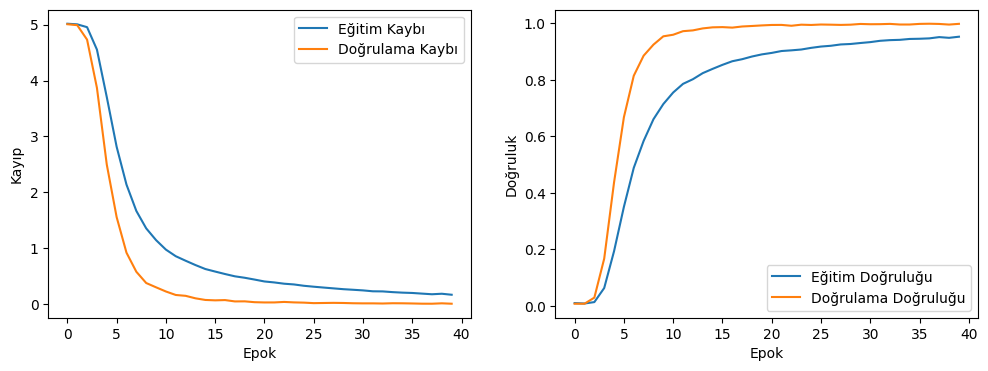

In [ ]:
# Eğitim ve doğrulama kayıp/doğruluk grafikleri
plt.figure(figsize=(12, 4))

# Kayıp grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')          # Eğitim kaybı
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')  # Doğrulama kaybı
plt.xlabel('Epok')                                               # X ekseni etiketi
plt.ylabel('Kayıp')                                              # Y ekseni etiketi
plt.legend()                                                     # Etiketleri göster

# Doğruluk grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')          # Eğitim doğruluğu
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')  # Doğrulama doğruluğu
plt.xlabel('Epok')                                                       # X ekseni etiketi
plt.ylabel('Doğruluk')                                                   # Y ekseni etiketi
plt.legend()                                                             # Etiketleri göster

plt.show()  # Grafikleri göster


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


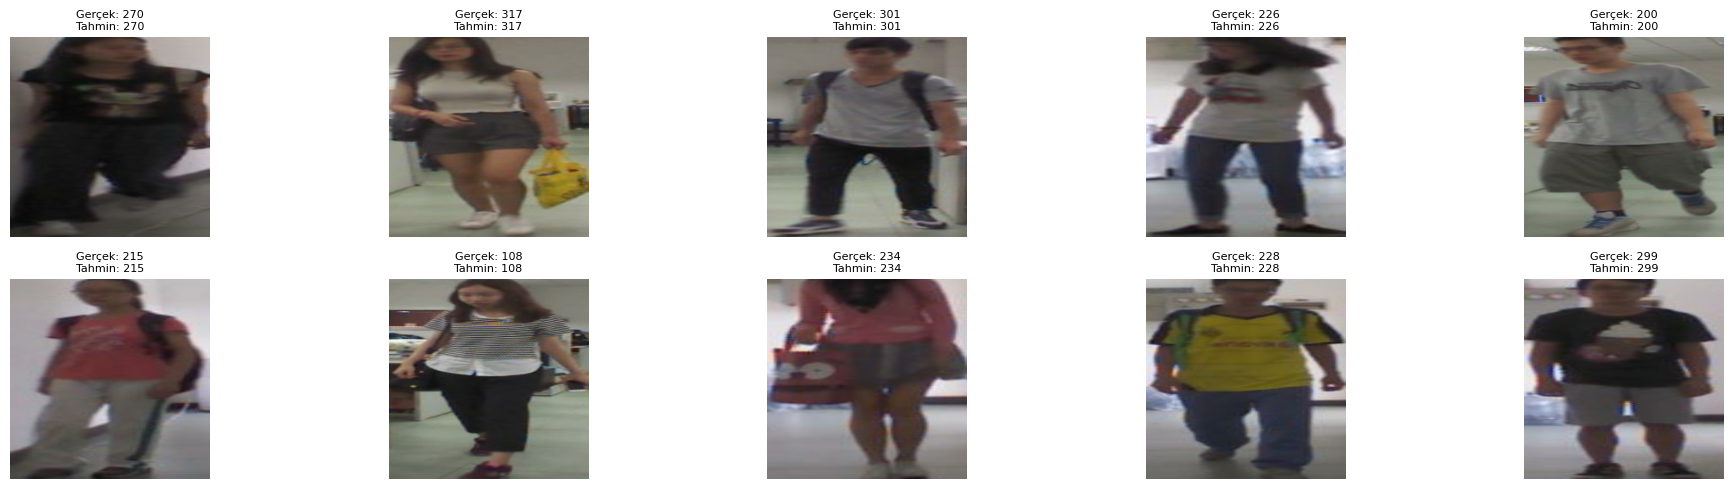

In [ ]:
# Veri setindeki tahminlerin görselleştirilmesi (normalize edilmiş veri)
for images, labels in rgb_val_dataset.take(1):  # Doğrulama veri setinden bir batch alıyoruz
    predictions = rgb_model.predict(images)     # Model ile tahmin yapıyoruz
    predicted_labels = np.argmax(predictions, axis=1)  # Tahmin edilen sınıfları alıyoruz

plt.figure(figsize=(20, 5))  # Figür boyutunu geniş olarak ayarlıyoruz
for i in range(10):          # İlk 10 görüntü için döngü
    plt.subplot(2, 5, i + 1)  # 2 satır ve 5 sütunlu düzen
    plt.imshow(images[i].numpy())  # Normalize edilmiş görüntüyü doğrudan gösteriyoruz
    plt.title(
        f"Gerçek: {rgb_class_names[labels[i]]}\nTahmin: {rgb_class_names[predicted_labels[i]]}",
        fontsize=8
    )  # Gerçek ve tahmin başlıkları
    plt.axis("off")  # Ekseni kapatıyoruz

plt.tight_layout()  # Düzeni sıkıştırıyoruz
plt.show()  # Grafiği gösteriyoruz


In [ ]:
import numpy as np

# Hatalı tahmin edilen indeksleri ve sayısını tutacak değişkenler
error_indices = []  # Yanlış tahmin edilen örneklerin indeksleri
error_count = 0     # Yanlış tahmin edilen toplam örnek sayısı

# Tüm sınıfları ve etiketleri kaydetmek için listeler
all_labels = []
all_predictions = []

# Doğrulama veri setinde döngü başlat
for batch_start, (rgb_images, labels) in enumerate(rgb_val_dataset):
    # RGB modelini tahmine sok
    predictions = rgb_model.predict(rgb_images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)  # Tahmin edilen sınıfları al

    # Gerçek etiketleri ve tahmin edilen sınıfları kaydet
    all_labels.extend(labels.numpy())
    all_predictions.extend(predicted_labels)

    # Yanlış tahmin edilen örnekleri kontrol et ve kaydet
    for i in range(len(labels)):
        if labels[i].numpy() != predicted_labels[i]:
            error_count += 1
            error_indices.append(batch_start * len(labels) + i)

# Sonuçları yazdır
print(f"Toplam Hatalı Tahmin Sayısı: {error_count}")
print(f"Hatalı Tahmin İndeksleri: {error_indices}")


Toplam Hatalı Tahmin Sayısı: 10
Hatalı Tahmin İndeksleri: [778, 1218, 1569, 1634, 2817, 3152, 3363, 3418, 3891, 4268]


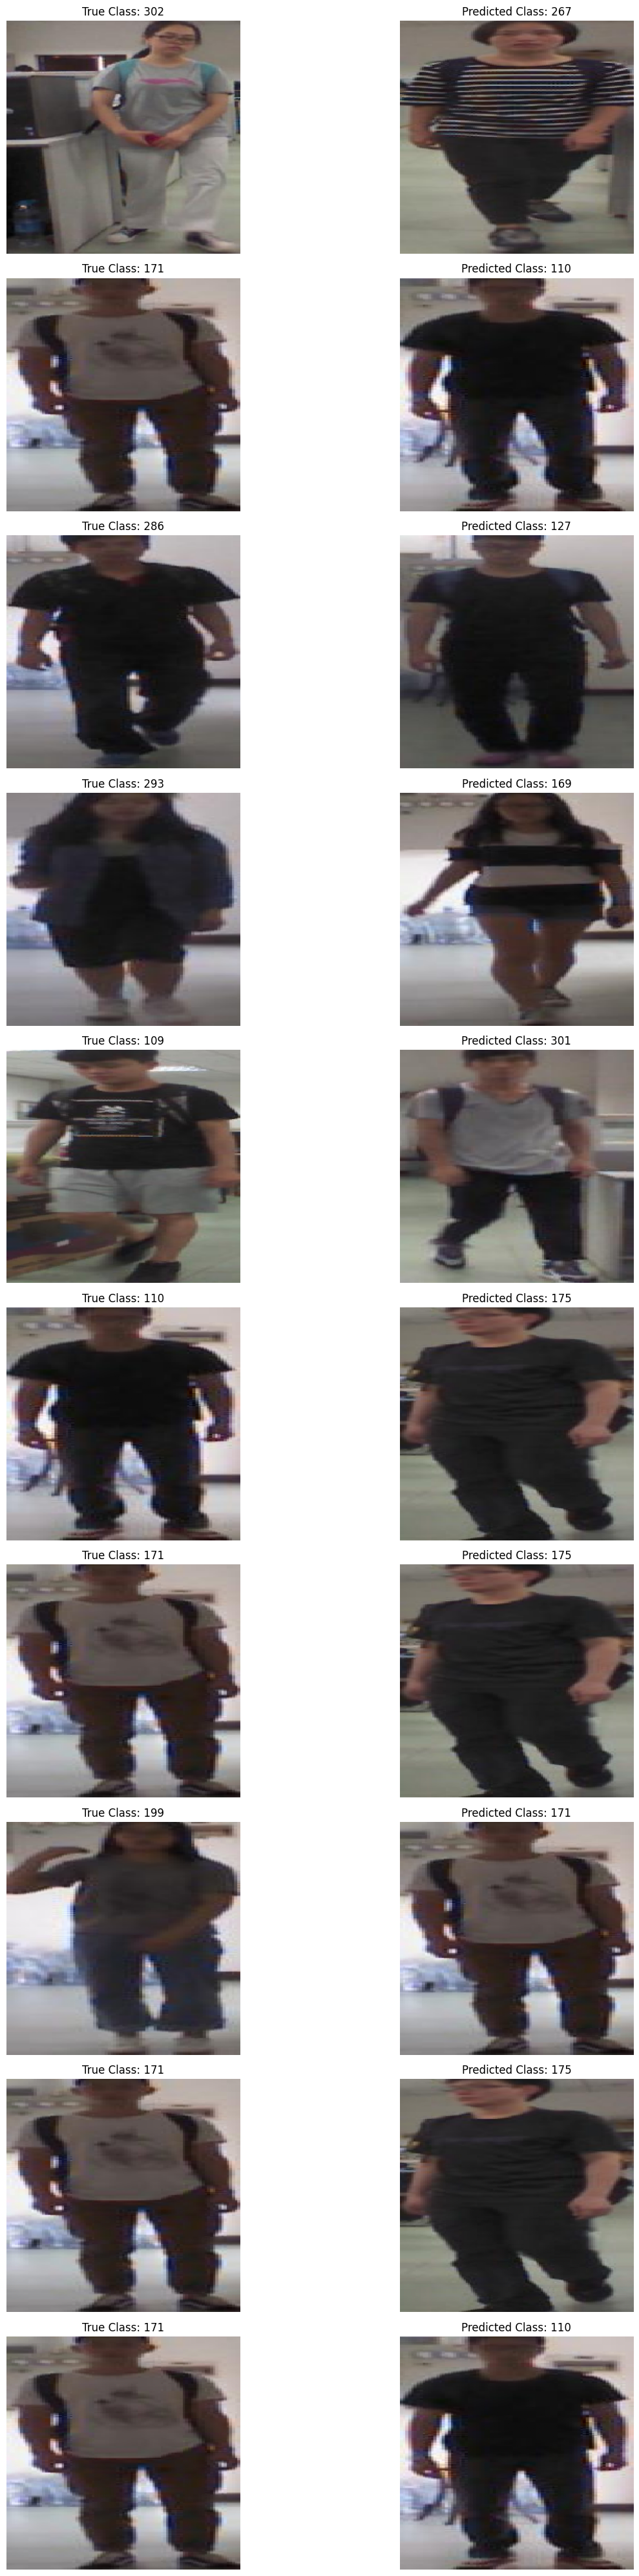

In [ ]:
import os  # Add this line at the beginning of your code

# RGB dizinlerinin sıfır ile başlayan isimlerini eşleştirmek
dizin_isimleri = os.listdir(rgb_val_dir)  # RGB doğrulama dizinindeki dosyaları alır
class_names = {i: str(name) for i, name in enumerate(sorted(dizin_isimleri))}  # Etiket ve dizin adlarını eşleştir

# Görüntü yükleme fonksiyonu
def load_image(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)  # Görüntüyü yükle
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Görüntüyü diziye çevir ve normalleştir
    return img_array

# Grafik için ayarlar
plt.figure(figsize=(15, 40))  # Grafik boyutunu belirle
num_to_plot = min(len(error_indices), 25)  # En fazla 25 görsel çizdir

# Hatalı tahmin edilen örneklerin görselleştirilmesi
for i, error_index in enumerate(error_indices[:num_to_plot]):
    true_label = all_labels[error_index]  # Gerçek sınıf etiketi
    predicted_label = all_predictions[error_index]  # Tahmin edilen sınıf etiketi

    try:
        # Gerçek sınıf dizinini belirle
        true_class_dir = os.path.join(rgb_val_dir, class_names[true_label])
        if not os.path.exists(true_class_dir):
            print(f"Gerçek sınıf {true_label} için dizin bulunamadı.")
            continue
        true_image_path = os.path.join(true_class_dir, os.listdir(true_class_dir)[0])
        true_image = load_image(true_image_path)

        # Tahmin edilen sınıf dizinini belirle
        pred_class_dir = os.path.join(rgb_val_dir, class_names[predicted_label])
        if not os.path.exists(pred_class_dir):
            print(f"Tahmin edilen sınıf {predicted_label} için dizin bulunamadı.")
            continue
        pred_image_path = os.path.join(pred_class_dir, os.listdir(pred_class_dir)[0])
        pred_image = load_image(pred_image_path)

        # Görselleri çiz
        plt.subplot(num_to_plot, 2, i * 2 + 1)
        plt.imshow(true_image)
        plt.title(f"True Class: {class_names[true_label]}")
        plt.axis('off')

        plt.subplot(num_to_plot, 2, i * 2 + 2)
        plt.imshow(pred_image)
        plt.title(f"Predicted Class: {class_names[predicted_label]}")
        plt.axis('off')
    except Exception as e:
        print(f"Error processing index {error_index}: {e}")
        continue

# Düzeni sıkıştır ve göster
plt.tight_layout()
plt.show()


# **TEST ASAMASI**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os


In [ ]:
# TensorFlow'dan model yükleme
from tensorflow.keras.models import load_model

# Modelin kaydedildiği dosya yolunu belirtin
model_path = '/content/drive/MyDrive/veriseti/rgb_model.h5'  # Modelin gerçek yolunu buraya yazın

# Modeli yükleyin
rgb_model = load_model(model_path)

# Modelin başarıyla yüklendiğini belirtin
print("### 1. Model Yüklendi ###")
print("Model başarıyla yüklendi.")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/veriseti/rgb_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def prepare_test_sets(data):
    print("Galeri Verileri:")
    gallery = data[data['camera'] == 'A']
    print(gallery)

    print("Probe B Verileri:")
    probe_B = data[data['camera'] == 'B']
    print(probe_B)

    print("Probe C Verileri:")
    probe_C = data[data['camera'] == 'C']
    print(probe_C)

    return gallery, probe_B, probe_C


In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path, target_size=(224, 224)):

    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension
    return img_array

def extract_features_from_nested_dirs(model, root_dir, camera_label):
    features, ids, cameras = [], [], []

    # Root dizininde tüm alt dizinleri tarar
    for root, _, files in os.walk(root_dir):
        for file_name in files:
            if file_name.endswith('.jpg') or file_name.endswith('.png'):
                file_path = os.path.join(root, file_name)
                print(f"Processing File: {file_path}")

                # Görüntüyü işleyip özellik çıkar
                img = preprocess_image(file_path)  # Call the preprocess_image function
                feature = model.predict(img)
                features.append(feature.squeeze())  # 1D vektör

                # ID'yi dosya yolundan al (klasör adı)
                id_label = os.path.basename(os.path.dirname(file_path))
                ids.append(id_label)
                cameras.append(camera_label)

    print(f"Extracted {len(features)} features from {root_dir}")
    return np.array(features), ids, cameras

# Örnek kullanımı:
a_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/test/A'
b_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/test/B'
c_dir = '/content/drive/MyDrive/veriseti/prcc/rgb/test/C'

features_A, ids_A, cameras_A = extract_features_from_nested_dirs(rgb_model, a_dir, 'A')
features_B, ids_B, cameras_B = extract_features_from_nested_dirs(rgb_model, b_dir, 'B')
features_C, ids_C, cameras_C = extract_features_from_nested_dirs(rgb_model, c_dir, 'C')

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Processing File: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/062/cropped_rgb562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing File: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/062/cropped_rgb520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Processing File: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/062/cropped_rgb565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Processing File: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/062/cropped_rgb142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Processing File: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/062/cropped_rgb418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Processing File: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/062/cropped_rgb154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Processing File: /content/drive/MyDrive/veriseti/prcc/rgb/test/C/062/cropped_rgb079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Processing File: /content/dri

In [ ]:
import pandas as pd

# Özellikleri birleştir
all_features = np.concatenate([features_A, features_B, features_C], axis=0)
all_ids = ids_A + ids_B + ids_C
all_cameras = cameras_A + cameras_B + cameras_C

# Test veri setini oluştur
test_data = pd.DataFrame({
    'features': list(all_features),
    'id': all_ids,
    'camera': all_cameras
})

print("Test veri seti hazır.")
print(test_data.head())


Test veri seti hazır.
                                            features   id camera
0  [5.2867454e-05, 0.00038693193, 9.296232e-07, 7...  001      A
1  [0.00013847194, 0.00085159263, 3.9754605e-07, ...  001      A
2  [0.007448928, 0.00605582, 0.00012121837, 4.109...  001      A
3  [4.5153065e-05, 0.00062137714, 1.1049854e-06, ...  001      A
4  [3.574584e-05, 0.00016586852, 6.353683e-09, 6....  001      A


In [ ]:
# Galeri ve sorgu setlerini oluştur
gallery, probe_B, probe_C = prepare_test_sets(test_data)

# Galeri ve sorgu setlerini kontrol et
print("Galeri Set Örnekleri:")
print(gallery.head())

print("\nProbe B Set Örnekleri:")
print(probe_B.head())

print("\nProbe C Set Örnekleri:")
print(probe_C.head())


Galeri Verileri:
                                               features   id camera
0     [5.2867454e-05, 0.00038693193, 9.296232e-07, 7...  001      A
1     [0.00013847194, 0.00085159263, 3.9754605e-07, ...  001      A
2     [0.007448928, 0.00605582, 0.00012121837, 4.109...  001      A
3     [4.5153065e-05, 0.00062137714, 1.1049854e-06, ...  001      A
4     [3.574584e-05, 0.00016586852, 6.353683e-09, 6....  001      A
...                                                 ...  ...    ...
3379  [2.604768e-06, 3.2638487e-09, 2.2494014e-11, 2...  322      A
3380  [6.514041e-08, 8.879755e-09, 1.594003e-09, 6.8...  322      A
3381  [3.078002e-08, 3.6453535e-11, 6.4351554e-12, 5...  322      A
3382  [9.668489e-07, 1.2251505e-09, 1.001597e-10, 2....  322      A
3383  [4.2517117e-06, 2.0161757e-09, 7.790769e-11, 1...  322      A

[3384 rows x 3 columns]
Probe B Verileri:
                                               features   id camera
3384  [0.03110544, 0.0025624651, 6.1884934e-06, 1.10... 

In [ ]:
# Rank-k doğruluk hesaplaması
def rank_k_matching(gallery, probe, k=1):
    correct_matches = 0
    for i in range(len(probe)):
        probe_feature = probe.iloc[i]['features']
        probe_id = probe.iloc[i]['id']

        # Galeri özellikleriyle mesafeleri hesapla
        distances = []
        for j in range(len(gallery)):
            gallery_feature = gallery.iloc[j]['features']
            dist = np.linalg.norm(np.array(probe_feature) - np.array(gallery_feature))
            distances.append((dist, gallery.iloc[j]['id']))

        # En küçük k mesafeyi al ve ID'leri kontrol et
        distances = sorted(distances, key=lambda x: x[0])
        top_k_ids = [item[1] for item in distances[:k]]

        # Eğer probe ID ilk k içerisinde varsa doğru eşleşme
        if probe_id in top_k_ids:
            correct_matches += 1

    return correct_matches / len(probe)

# Rank-1 doğruluk hesapla
rank_1_accuracy_B = rank_k_matching(gallery, probe_B, k=1)
rank_1_accuracy_C = rank_k_matching(gallery, probe_C, k=1)
# Rank-5 ve Rank-10 doğruluk hesaplama
rank_5_accuracy_B = rank_k_matching(gallery, probe_B, k=5)
rank_5_accuracy_C = rank_k_matching(gallery, probe_C, k=5)

# Sonuçları yazdır
print("### 5. Adım: Rank-k Doğruluk Hesaplandı ###")
print(f"Rank-1 Accuracy (Gallery vs Probe B): {rank_1_accuracy_B:.4f}")
print(f"Rank-1 Accuracy (Gallery vs Probe C): {rank_1_accuracy_C:.4f}")
print(f"Rank-5 Accuracy (Gallery vs Probe B): {rank_5_accuracy_B:.4f}")
print(f"Rank-5 Accuracy (Gallery vs Probe C): {rank_5_accuracy_C:.4f}")


### 5. Adım: Rank-k Doğruluk Hesaplandı ###
Rank-1 Accuracy (Gallery vs Probe B): 0.4547
Rank-1 Accuracy (Gallery vs Probe C): 0.0706
Rank-5 Accuracy (Gallery vs Probe B): 0.6269
Rank-5 Accuracy (Gallery vs Probe C): 0.1256


In [ ]:
# Rank-10 ve Rank-20 doğruluk hesaplama

rank_10_accuracy_B = rank_k_matching(gallery, probe_B, k=10)
rank_10_accuracy_C = rank_k_matching(gallery, probe_C, k=10)

rank_20_accuracy_B = rank_k_matching(gallery, probe_B, k=20)
rank_20_accuracy_C = rank_k_matching(gallery, probe_C, k=20)

# Sonuçları yazdır
print("### Rank-5 ve Rank-10 Doğruluk Oranları ###")

print(f"Rank-10 Accuracy (Gallery vs Probe B): {rank_10_accuracy_B:.4f}")
print(f"Rank-10 Accuracy (Gallery vs Probe C): {rank_10_accuracy_C:.4f}")
print(f"Rank-20 Accuracy (Gallery vs Probe B): {rank_20_accuracy_B:.4f}")
print(f"Rank-20 Accuracy (Gallery vs Probe C): {rank_20_accuracy_C:.4f}")


### Rank-5 ve Rank-10 Doğruluk Oranları ###
Rank-10 Accuracy (Gallery vs Probe B): 0.7018
Rank-10 Accuracy (Gallery vs Probe C): 0.1679
Rank-20 Accuracy (Gallery vs Probe B): 0.7560
Rank-20 Accuracy (Gallery vs Probe C): 0.2258
